<a href="https://colab.research.google.com/github/Taikatou/economy-monte-carlo/blob/main/exp_2_monster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gym
from gym import spaces
import numpy as np

In [ ]:
import gym
from stable_baselines3 import DQN, PPO, SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy


/home/taikatou/anaconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from enum import IntEnum, Enum
class MonsterType(Enum):
    NORMAL = 1
    POISON = 2
    FLYING = 3
    ROCK = 4

class Monster:
    def __init__(self, base_victory_chance, experience_points, monster_type):
        base_victory_chance *= 0.7
        self.victory_chances = [min(base_victory_chance * (1.4 ** level), 1.0) for level in range(10)]
        for x in range(len(self.victory_chances)):
            if self.victory_chances[x] < 0.3:
              self.victory_chances[x] = 0
        print(self.victory_chances)
        self.experience_points = experience_points
        self.monster_type = monster_type

class Environment:
    def __init__(self, name, monsters, spawn_probabilities):
        self.name = name
        self.monsters = monsters
        self.spawn_probabilities = spawn_probabilities

In [ ]:
# Example initialization
# Using a dictionary for monsters
monsters = {
    "Gorilla": Monster(0.6, 50, MonsterType.ROCK),  # Base chance 60%, medium difficulty
    "Owl": Monster(0.7, 60, MonsterType.FLYING),      # Base chance 70%, easier
    "Snake": Monster(0.5, 75, MonsterType.POISON),    # Base chance 50%, more difficult
    "Bear": Monster(0.6, 70, MonsterType.NORMAL),
    "Narwhal": Monster(0.18, 160, MonsterType.ROCK),
    "Bull": Monster(0.1, 140, MonsterType.NORMAL),
    "Dragon": Monster(0.05, 200, MonsterType.FLYING),
    "Lion": Monster(0.8, 15, MonsterType.ROCK),
    "Serpant": Monster(0.2, 120, MonsterType.POISON)
}

# Adjusting environment initialization accordingly
environments = [
    Environment("Forest", ["Gorilla", "Owl"], [0.7, 0.3]),
    Environment("Mountain", ["Snake", "Bear"], [0.6, 0.4]),
    Environment("Sea", ["Narwhal", "Serpant"], [0.5, 0.5]),
    Environment("Volcano", ["Dragon", "Bull"], [0.3, 0.7])

    # Add other environments as needed
]

[0.42, 0.588, 0.8231999999999998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.48999999999999994, 0.6859999999999998, 0.9603999999999997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.35, 0.48999999999999994, 0.6859999999999998, 0.9603999999999997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.42, 0.588, 0.8231999999999998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 0, 0, 0.34574399999999994, 0.4840415999999999, 0.6776582399999997, 0.9487215359999998, 1.0, 1.0, 1.0]
[0, 0, 0, 0, 0, 0.37647679999999983, 0.5270675199999998, 0.7378945279999995, 1.0, 1.0]
[0, 0, 0, 0, 0, 0, 0, 0.3689472639999998, 0.5165261695999996, 0.7231366374399996]
[0.5599999999999999, 0.7839999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 0, 0, 0.3841599999999999, 0.5378239999999999, 0.7529535999999997, 1.0, 1.0, 1.0, 1.0]


In [ ]:
class AgentType(IntEnum):
    BRAWLER = 1
    SWORDSMAN = 2
    MAGE = 3

modifiers = {
    AgentType.BRAWLER: {
        MonsterType.ROCK: 1.2,
        MonsterType.FLYING: 0.7
    },
    AgentType.SWORDSMAN: {
        MonsterType.POISON: 1.2,
        MonsterType.ROCK: 0.7
    },
    AgentType.MAGE: {
        MonsterType.FLYING: 1.2,
        MonsterType.POISON: 0.7
    }
}

In [ ]:
import random

class DeepQBanditEnv(gym.Env):
    metadata = {'render.modes': ['console']}

    def __init__(self, environments):
        super(DeepQBanditEnv, self).__init__()
        self.environments = environments
        self.num_environments = len(environments)
        self.current_level = 0
        self.current_exp = 0
        self.action_space = spaces.Discrete(self.num_environments)
        self.observation_space = spaces.Box(low=np.array([0]*10 + [0] + [0]*3), high=np.array([1]*10 + [10530] + [1]*3), dtype=np.int32)
        self.agent_type = random.choice(list(AgentType))

    def reset(self):
        self.current_level = 0
        self.current_exp = 0
        self.agent_type = random.choice(list(AgentType))
        return self._get_observation()

    def _get_observation(self):
        # Create one-hot encoded vector for current level
        level_one_hot = np.zeros(10)
        if self.current_level > 0:  # Encode as one-hot if level is within 1-10
            level_one_hot[self.current_level - 1] = 1
        # Combine the one-hot encoded level with other observations
        agent_one_hot= np.zeros(3)
        agent_one_hot[int(self.agent_type) - 1] = 1
        return np.concatenate([level_one_hot, [self.current_exp], agent_one_hot])


    def step(self, action):
        reward = - 0.05
        old_level = self.current_level
        environment = self.environments[action]
        monster_key = np.random.choice(environment.monsters, p=environment.spawn_probabilities)
        monster = monsters[monster_key]
        victory_chance = self.calculate_victory_chance(monster, self.current_level)
        if random.random() < victory_chance:
            self.current_exp += monster.experience_points
            while self.current_level < 10 and self.current_exp >= level_up_exp[self.agent_type][self.current_level]:
                self.current_level += 1
                self.current_exp -= level_up_exp[self.agent_type][self.current_level - 1]
        done = self.current_level == 10
        if done:
            reward += 1
        return self._get_observation(), reward, done, {}

    def render(self, mode='console'):
        if mode == 'console':
            print(f"Current Level: {self.current_level}, Current EXP: {self.current_exp}")

    def calculate_victory_chance(self, monster, level):
        base_chance = monster.victory_chances[level]
        # Get modifier from dictionary, defaulting to 1 if not found
        modifier = modifiers.get(self.agent_type, {}).get(monster.monster_type, 1)
        adjusted_chance = base_chance * modifier
        # Ensure the chance is within bounds (0.05 to 0.95)
        return max(adjusted_chance, 0)

level_up_exp = {
    AgentType.BRAWLER: [30, 60, 90, 140, 380, 760, 1220, 2840, 4861, 9360],
    AgentType.MAGE: [23, 45, 68, 105, 285, 570, 915, 2130, 3646, 7020],
    AgentType.SWORDSMAN: [34, 68, 101, 158, 428, 855, 1373, 3195, 5469, 10530]

}
env = DeepQBanditEnv(environments)
print(env.observation_space)

Box(0, [    1     1     1     1     1     1     1     1     1     1 10530     1
     1     1], (14,), int32)


In [ ]:
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
class RewardLoggerCallback(BaseCallback):
    def __init__(self, check_freq):
        super(RewardLoggerCallback, self).__init__()
        self.check_freq = check_freq
        self.rewards = []

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            episode_rewards = self.model.ep_info_buffer
            if episode_rewards:
                self.rewards.append(episode_rewards[-1]['r'])
        return True

reward_logger = RewardLoggerCallback(check_freq=1000)

In [ ]:
def make_env(env_class, rank, environments):
    """
    Utility function for multiprocessed env.

    :param env_class: the class of the environment to instantiate
    :param rank: index of the subprocess env
    :param environments: the environments to pass to the env class
    :return: the instantiated environment
    """
    def _init():
        env = env_class(environments)
        env.seed(rank)
        return env
    return _init

In [ ]:
import torch
device = torch.device("cpu")

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback

vec_env = make_vec_env(lambda: env, n_envs=24)
print(vec_env.observation_space)
# Initialize SAC model

n_steps = 2048  # or higher, depending on episode length and memory constraints
batch_size = 64  # Increase as per computational capacity
learning_rate = 2.5e-4  # Tune based on empirical results
gae_lambda = 0.95  # Typically between 0.9 to 0.99
entropy_coef = 0.01  # Tune based on the need for exploration

checkpoint_callback = CheckpointCallback(save_freq=10000, save_path='./logs/', name_prefix='ppo_model')
eval_callback = EvalCallback(env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=500,
                             deterministic=True, render=False)
model = PPO("MlpPolicy", vec_env, verbose=1,
            batch_size=batch_size,
            n_steps=n_steps,
            learning_rate=learning_rate,
            gae_lambda=gae_lambda,
            ent_coef=entropy_coef)
# Train the model


Box(0, [    1     1     1     1     1     1     1     1     1     1 10530     1
     1     1], (14,), int32)
Using cuda device


In [ ]:
import torch
model.policy.to('cpu')
input_shape = (14,)
dummy_input = torch.randn(1, *input_shape)  # Adjust the shape accordingly

# Export the model
torch.onnx.export(model.policy,  # The model's policy network
                  dummy_input,
                  "monster.onnx",  # Output path
                  export_params=True,
                  opset_version=10,  # Adjust based on your needs
                  do_constant_folding=True,
                  input_names=['input'],  # Names should match model's input
                  output_names=['output'],  # And output
                  dynamic_axes={'input': {0: 'batch_size'},  # For variable batch size
                                'output': {0: 'batch_size'}})

/home/taikatou/anaconda3/envs/tf/lib/python3.10/site-packages/stable_baselines3/common/distributions.py:87: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if deterministic:
/home/taikatou/anaconda3/envs/tf/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:3900: UserWarning: ONNX export unsqueeze with negative axis -1 might cause the onnx model to be incorrect. Negative axis is not supported in ONNX. Axis is converted to 1 based on input shape at export time. Passing an tensor of different rank in execution will be incorrect.
  warnings.warn(
/home/taikatou/anaconda3/envs/tf/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:1160: UserWarning: ONNX export squeeze with negative axis -1 might cause the onnx model to be incorrect. Negative axis is not suppo

In [ ]:
model.learn(total_timesteps=2e6, callback=reward_logger)

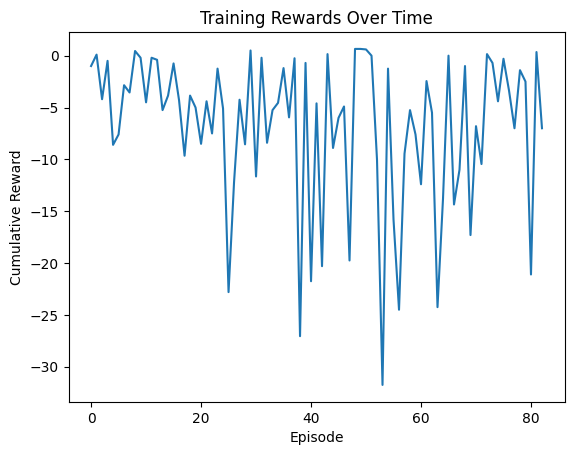

In [ ]:
# Plot the rewards
plt.plot(reward_logger.rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Training Rewards Over Time')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from functools import partial


num_levels = 10
average_times_by_type = {}
action_counts_by_type = {}

def simulate_level_ups_parallel(num_agents, agent_type, use_random_policy, num_levels, num_environments, num_iterations):
    partial_simulate = partial(simulate_level_up, agent_type=agent_type, use_random_policy=use_random_policy, num_levels=num_levels, num_environments=num_environments, num_iterations=num_iterations)

    with ProcessPoolExecutor() as executor:
        # Map the partial function across the range of agent IDs
        print(num_agents)
        results = list(executor.map(partial_simulate, range(num_agents)))

    combined_action_counts = np.sum([result[0] for result in results], axis=0)
    combined_steps_taken = sum([result[1] for result in results], [])

    return combined_action_counts, combined_steps_taken



def simulate_level_up(agent_id, agent_type, use_random_policy, num_levels, num_environments, num_iterations):
    action_counts = np.zeros((num_levels, num_environments))
    rec_env = DeepQBanditEnv(environments) # Assume environments is defined elsewhere
    steps_taken = []
    for iteration in range(num_iterations):
        # Create a new instance of the environment for this simulation
        obs = rec_env.reset()
        rec_env.agent_type = agent_type
        done = False
        time_steps = 0
        ew_level = np.argmax(obs[:10])
        steps = 0
        while not done:
            if use_random_policy:
                action = rec_env.action_space.sample()  # Random action
            else:
                action, _states = model.predict(obs, deterministic=False)  # Predicted action
            obs, rewards, done, info = rec_env.step(action)
            new_level = np.argmax(obs[:10]) - 1
            # Record the chosen action for the current level
            if new_level <= num_levels:
                action_counts[new_level, action] += 1

            steps += 1
        steps_taken.append(steps)

    return (action_counts, steps_taken)

# Initialize statistics
num_levels = 10
average_times_by_type = {}
action_counts_by_type = {}

num_iterations = 500
num_levels = 9
num_environments = 6
model.policy.to('cpu')

for agent_type in AgentType:
    # Run with trained policy
    action_counts_by_type[(agent_type, False)] = simulate_level_ups_parallel(24, agent_type, False, num_levels, num_environments, num_iterations)
    # Run with random policy
    action_counts_by_type[(agent_type, True)] = simulate_level_ups_parallel(24, agent_type, True, num_levels, num_environments, num_iterations)

24
24
24
24
24
24


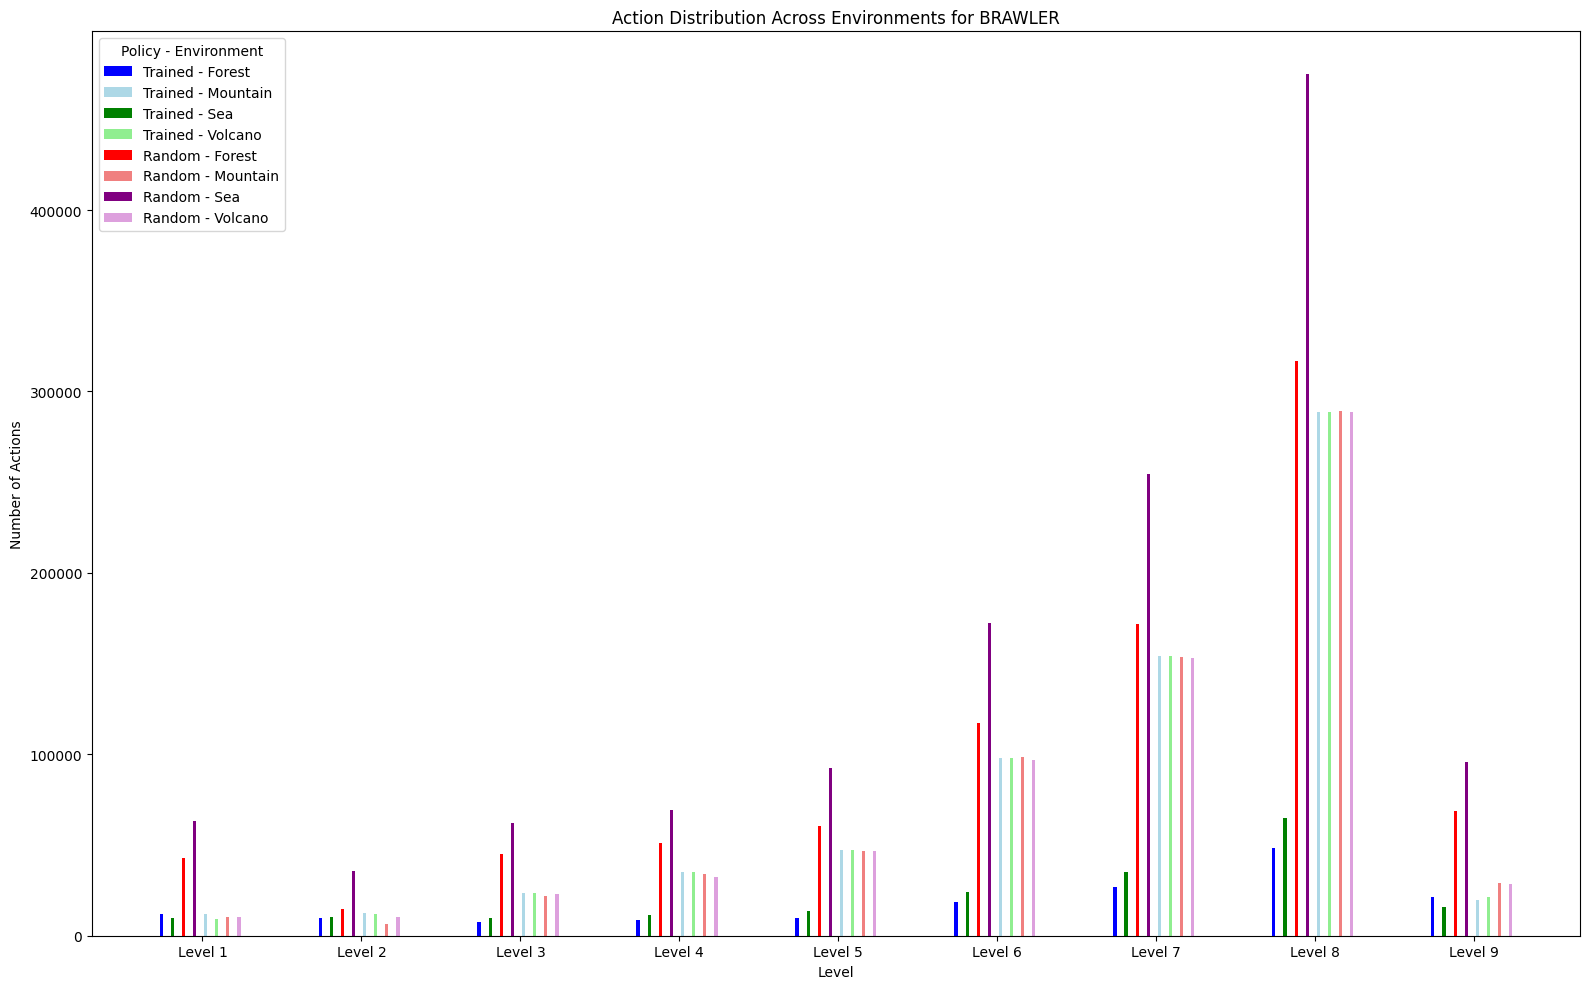

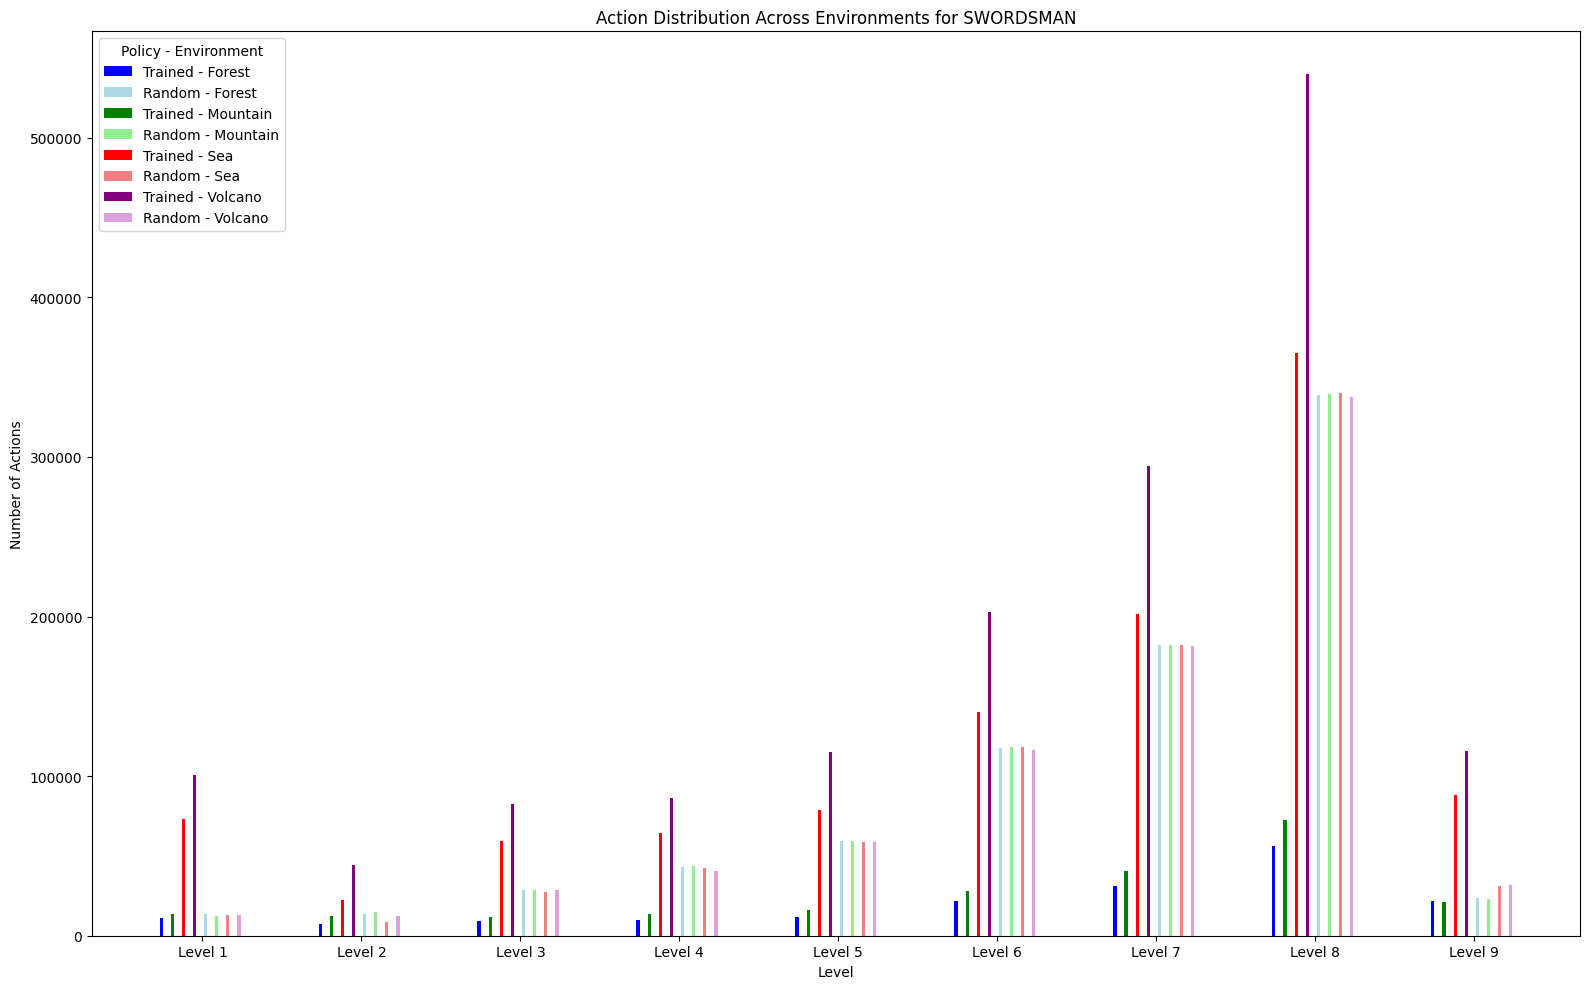

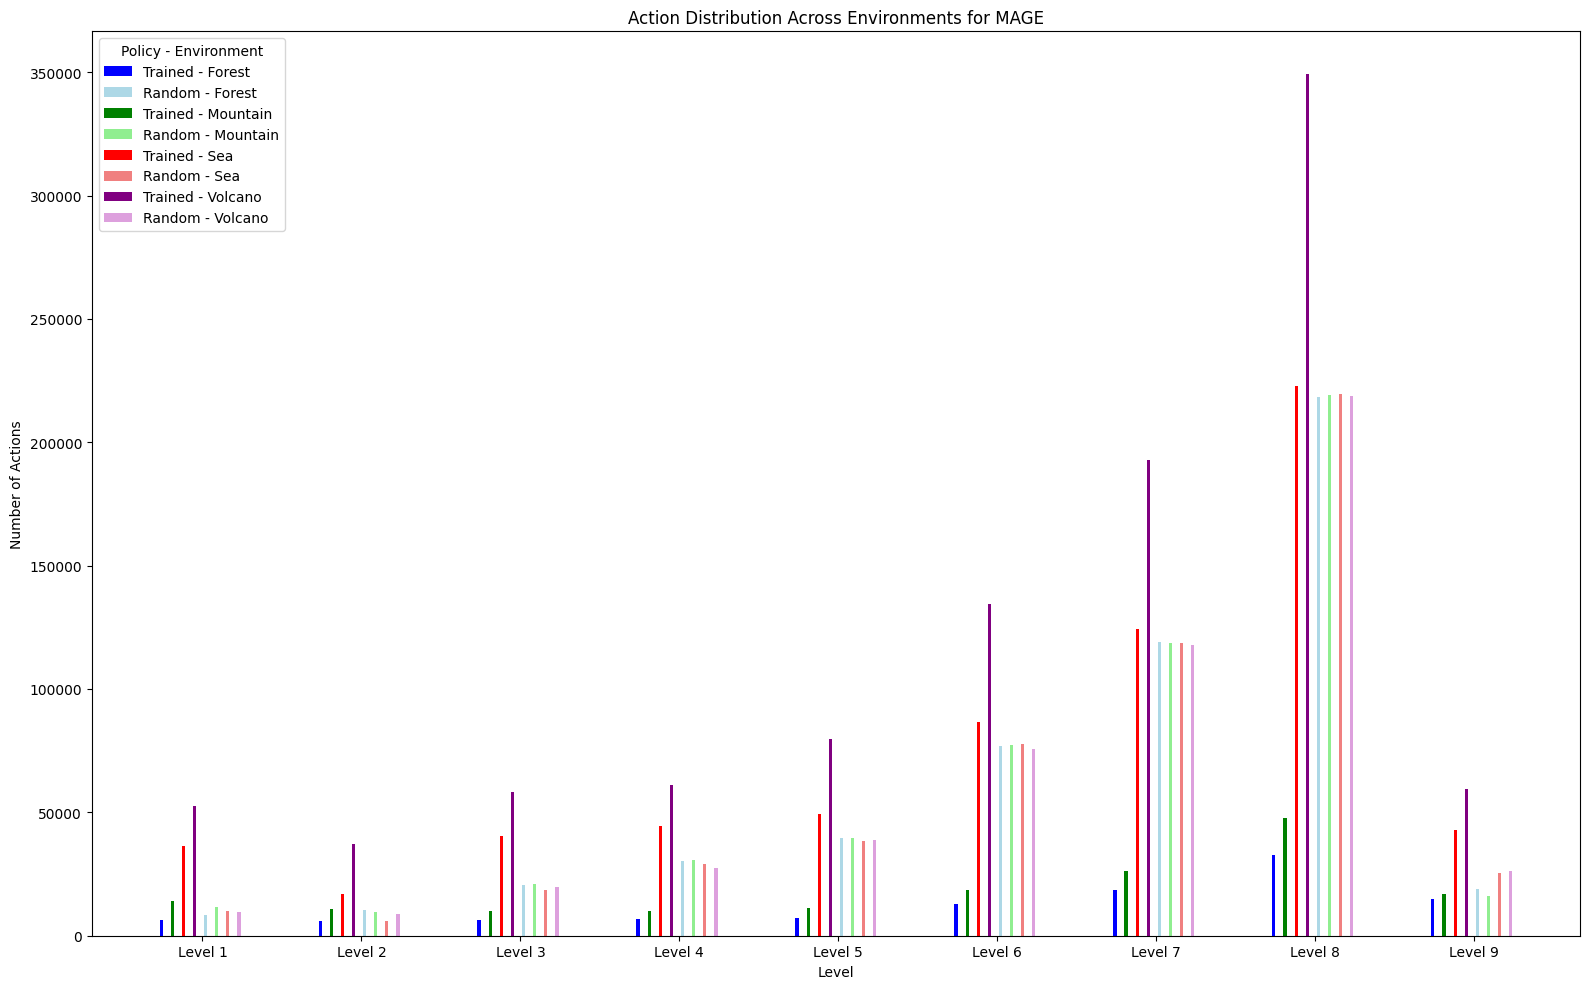

In [ ]:
# Assuming 'action_counts_by_type' is a dictionary with keys as (AgentType, bool) and values as a NumPy array of shape (num_levels, num_environments)
# Initialize the number of levels, environments, and the text labels for the environments
num_levels = 9  # Total number of levels
environments_text = ['Forest', 'Mountain', 'Sea', 'Volcano'] #, 'Jungle', 'Sky']  # Environment names

# Define the bar width, the spacing between bars, and the overall group width
bar_width = 0.02
spacer_width = 0.05
group_width = num_environments * (bar_width * 2 + spacer_width)

# Calculate the x-axis positions for the groups of bars
index = np.arange(1, num_levels + 1)


# Define colors for trained and random bars
# Colors for the 'Trained' bars
trained_colors = ['blue', 'green', 'red', 'purple', 'orange', 'orchid']

# Lighter colors for the 'Random' bars
random_colors = ['lightblue', 'lightgreen', 'lightcoral', 'plum', 'yellow', 'pink']

# Plotting the Bar Charts with Clustered Groups for Each Policy
for agent_type in AgentType:
    legend_handles = []
    fig, ax = plt.subplots(figsize=(20, 10))

    # Offset initialization
    offset = -group_width/2.0 + bar_width/2.0

    for i, env_name in enumerate(environments_text):
        trained_positions = index + offset + i * (bar_width + spacer_width)
        random_positions = index + offset + i * (bar_width + spacer_width) + (bar_width*4) + (spacer_width*4)

        trained_counts = action_counts_by_type[(agent_type, False)][0][:, i]
        random_counts = action_counts_by_type[(agent_type, True)][0][:, i]

        trained_bar = ax.bar(trained_positions, trained_counts, bar_width, label=f'Trained - {env_name}', color=trained_colors[i])
        random_bar = ax.bar(random_positions, random_counts, bar_width, label=f'Random - {env_name}', color=random_colors[i])
        if agent_type == list(AgentType)[0]:
            legend_handles.append(trained_bar[0])
            legend_handles.append(random_bar[0])

    # Adding the legend outside of the plot area to the right
    legend_labels = [f'Trained - {env}' for env in environments_text] + \
                    [f'Random - {env}' for env in environments_text]
    ax.legend(handles=legend_handles, labels=legend_labels, title='Policy - Environment', loc='upper left')

    # Setting the x-axis labels and title
    ax.set_xticks(index)
    ax.set_xticklabels([f'Level {lvl}' for lvl in range(1, num_levels + 1)])
    ax.set_xlabel('Level')
    ax.set_ylabel('Number of Actions')
    ax.set_title(f'Action Distribution Across Environments for {agent_type.name}')

    plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust layout to make room for legend
    filename = f'Action_Distribution_{agent_type.name}_2.png'
    plt.savefig(filename)

    # Show the plot
    plt.show()

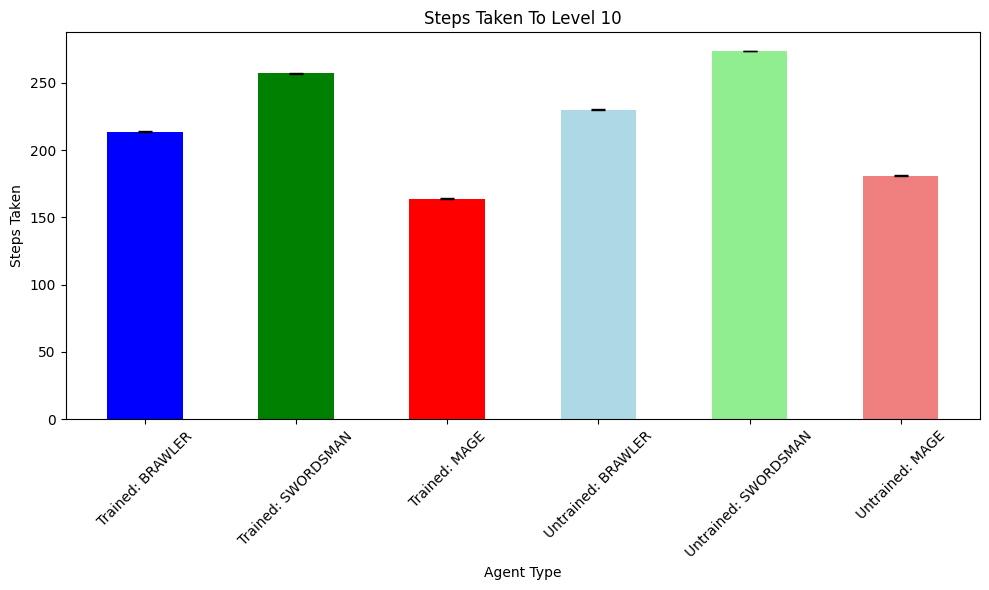

In [ ]:
from scipy import stats
from statistics import mean, stdev
import numpy as np

categories = []
data = []



confidence_intervals = []
for agent_type in AgentType:
    categories.append("Trained: " + agent_type.name)
    data_points = action_counts_by_type[(agent_type, False)][1]
    sem = stats.sem(data_points)  # Standard Error of Mean
    confidence_interval = stats.t.interval(0.95, len(data_points)-1, loc=mean(data_points), scale=sem)
    confidence_intervals.append((mean(data_points), confidence_interval))
    data.append(mean(action_counts_by_type[(agent_type, False)][1]))

for agent_type in AgentType:
    categories.append("Untrained: " + agent_type.name)
    data_points = action_counts_by_type[(agent_type, True)][1]
    sem = stats.sem(data_points)  # Standard Error of Mean
    confidence_interval = stats.t.interval(0.95, len(data_points)-1, loc=mean(data_points), scale=sem)
    confidence_intervals.append((mean(data_points), confidence_interval))
    data.append(mean(action_counts_by_type[(agent_type, True)][1]))


plt.figure(figsize=(10, 6))  # Width, Height in inches

# Error bars represent half the length of the confidence interval
error_bars = [(interval[1] - mean) for mean, interval in confidence_intervals]

colors = ['blue', 'green', 'red', 'lightblue', 'lightgreen', 'lightcoral']

# Create bar chart with error bars
plt.bar(categories, data, width=0.5, color=colors, yerr=error_bars, capsize=5)

# Adding title and labels
plt.title('Steps Taken To Level 10')
plt.xlabel('Agent Type')
plt.ylabel('Steps Taken')
# Rotate category names for better fit
plt.xticks(rotation=45)

# Save the plot as a PNG file
plt.tight_layout()  # Adjusts subplot params for the subplot(s) to fit in the figure area.
plt.savefig('steps_taken.png', dpi=300, bbox_inches='tight')  # Saves the plot to a PNG file

# Display the chart
plt.show()


In [ ]:
# The actual neural network model is under model.policy
nn_model = model.policy

In [ ]:
import pygame
from pygame.locals import *

class PygameWrapper:
    def __init__(self, env):
        self.env = env
        self.screen = None
        self.clock = None
        self.font = None
        self.init_pygame()

    def init_pygame(self):
        pygame.init()
        self.screen = pygame.display.set_mode((800, 600))
        pygame.display.set_caption('DeepQ Bandit Environment')
        self.clock = pygame.time.Clock()
        self.font = pygame.font.Font(None, 36)

    def draw_buttons(self):
        button_width, button_height = 100, 50
        button_colors = [(100, 200, 100), (200, 100, 100), (100, 100, 200), (200, 200, 100)]
        environments = ['Forest', 'Mountain', 'Sea', 'Volcano']

        for i, env in enumerate(environments):
            button_x = 50 + i * (button_width + 10)  # Horizontal spacing
            button_y = 500  # Vertical position
            button_rect = pygame.Rect(button_x, button_y, button_width, button_height)
            pygame.draw.rect(self.screen, button_colors[i], button_rect)

            text_surface = self.font.render(env, True, (255, 255, 255))
            text_rect = text_surface.get_rect(center=button_rect.center)
            self.screen.blit(text_surface, text_rect)

    def draw_log(self, log_messages):
        log_x, log_y = 50, 400
        for msg in log_messages:
            text_surface = self.font.render(msg, True, (0, 0, 0))
            self.screen.blit(text_surface, (log_x, log_y))
            log_y += 30  # Move to the next line

    def draw_progress_bar(self, current_exp, level_up_exp):
        bar_width = 300
        bar_height = 20
        progress_x, progress_y = 250, 50
        progress_width = (current_exp / level_up_exp) * bar_width

        # Draw the background bar
        pygame.draw.rect(self.screen, (200, 200, 200), [progress_x, progress_y, bar_width, bar_height])
        # Draw the progress
        pygame.draw.rect(self.screen, (100, 200, 100), [progress_x, progress_y, progress_width, bar_height])

    def draw_level_text(self, level):
        level_x, level_y = 50, 50
        level_text = f"Level: {level}"
        text_surface = self.font.render(level_text, True, (0, 0, 0))
        self.screen.blit(text_surface, (level_x, level_y))

    def main_loop(self):
        running = True
        while running:
            for event in pygame.event.get():
                if event.type == QUIT:
                    running = False
                # Handle other events such as button clicks

            self.screen.fill((255, 255, 255))  # Fill the screen with white

            # Draw the interface components
            self.draw_buttons()
            self.draw_log(["Battle won!", "Gained 20 EXP"])  # Example log messages
            self.draw_progress_bar(self.env.current_exp, level_up_exp[self.env.agent_type][self.env.current_level])
            self.draw_level_text(self.env.current_level)

            pygame.display.flip()
            self.clock.tick(60)

        pygame.quit()

env = DeepQBanditEnv(environments)

# Create and run the Pygame wrapper
wrapper = PygameWrapper(env)
wrapper.main_loop()

KeyboardInterrupt: 